In [1]:
import pandas as pd
import time
import csv
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import os
import cv2
from torch.optim.lr_scheduler import ReduceLROnPlateau 
from PIL import Image
import seaborn as sns
from PIL import ImageOps
import torchvision.models as models
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torchvision")
import numpy as np
import pandas as pd
import time
import csv
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import os
import cv2
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import seaborn as sns
from PIL import ImageOps
import torchvision.models as models


# Assume device is set correctly based on your environment
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Check if GPU is available
use_gpu = torch.cuda.is_available()
print("GPU Available:", use_gpu)

# Paths to the files with training, validation, and test sets.
total_train_data = pd.read_csv('/kaggle/input/chexpert-v10-small/CheXpert-v1.0-small/train.csv')
print("Total data length:", len(total_train_data))

data_frontal = total_train_data[total_train_data['Path'].str.contains("frontal")]  # Use only frontal images
print("Total Frontal data length:", len(data_frontal))

Testdata = data_frontal.head(500)
Testdata.to_csv('/kaggle/working/test_mod.csv', index=False)
print("Test data length:", len(Testdata))





GPU Available: True
Total data length: 223414
Total Frontal data length: 191027
Test data length: 500


In [2]:
Train_data_frontal = data_frontal[500:150000]
Train_data_frontal.to_csv('/kaggle/working/train_mod.csv', index=False)
print("Train data length:", len(Train_data_frontal))

Validdata = pd.read_csv('/kaggle/input/chexpert-v10-small/CheXpert-v1.0-small/valid.csv')
Validdata = Validdata[Validdata['Path'].str.contains("frontal")]  # Use only frontal images
Validdata.to_csv('/kaggle/working/valid_mod.csv', index=False)
print("Valid data length:", len(Validdata))

pathFileTrain = '/kaggle/working/train_mod.csv'
pathFileValid = '/kaggle/working/valid_mod.csv'
pathFileTest = '/kaggle/working/test_mod.csv'


Train data length: 149500
Valid data length: 202


In [3]:
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax',
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
class_idx = list(range(14)) 

In [4]:
num_classes = 14  # dimension of the output and number of classes
lr=0.001
fraction=0.75

batch_size = 64
num_clients=5

max_epochs=5
com_round=3


betas=(0.9, 0.999) # betas for optimizer
eps_optim= 1e-8 #for optimizer
wtdecay=0 #for optimizer


privacy_epsilon =15 # Higher mean less privacy - Range ( 0.1 - 10) Quantifies Privacy Guaranttee 
max_grad_norm=1.2# limits Magnitude of gradients before adding noise - Range (0.5 - 1 - 10) # opacus 1.2
#noise_multiplier=0.5 # Lower noise_multiplier for less privacy (better accuracy)  - Range (0.2 , 10)
data_per_client=len(Train_data_frontal)/num_clients

delta=1/(data_per_client)# slightly increase for less privacy - Range ( 10-5 to 10-6) - controls privacy leak
print("delta=:", delta)
min_delta=delta*0.9
print("min_delta=:", min_delta)

delta=: 3.3444816053511705e-05
min_delta=: 3.0100334448160535e-05


In [5]:
csv_root_path = total_train_data # Path to the CSV files
train_csv_filename=pathFileTrain 

valid_csv_filename = pathFileValid
pathFileTest = '/kaggle/working/test_mod.csv'
image_root_path = '/kaggle/input/chexpert-v10-small/'  # Path to the images

Class Counts Train dataset:
No Finding                    13086
Enlarged Cardiomediastinum    27438
Cardiomegaly                  30730
Lung Opacity                  81125
Lung Lesion                    7084
Edema                         60260
Consolidation                 44649
Pneumonia                     17819
Atelectasis                   46064
Pneumothorax                  52845
Pleural Effusion              89385
Pleural Other                  3834
Fracture                       7719
Support Devices               88753
dtype: int64


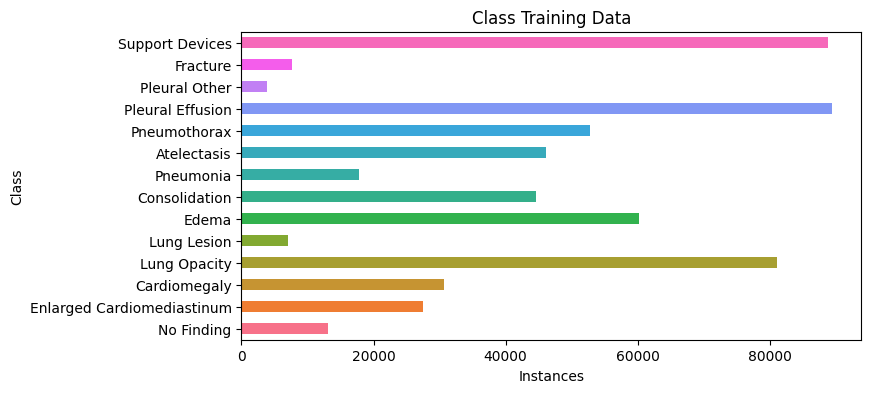

In [6]:
pathFileTrain_df = pd.read_csv(pathFileTrain)
class_counts = pathFileTrain_df[class_names].count()
print("Class Counts Train dataset:")
print(class_counts)
plt.figure(figsize=(8, 4))
colors = sns.color_palette("husl", len(class_counts))
class_counts.plot(kind='barh', color=colors)
plt.ylabel('Class')
plt.xlabel('Instances')
plt.title('Class Training Data')
plt.show()


Class Counts Valid dataset (number of positive cases):
No Finding                     26.0
Enlarged Cardiomediastinum    105.0
Cardiomegaly                   66.0
Lung Opacity                  117.0
Lung Lesion                     1.0
Edema                          42.0
Consolidation                  32.0
Pneumonia                       8.0
Atelectasis                    75.0
Pneumothorax                    7.0
Pleural Effusion               64.0
Pleural Other                   1.0
Fracture                        0.0
Support Devices                99.0
dtype: float64


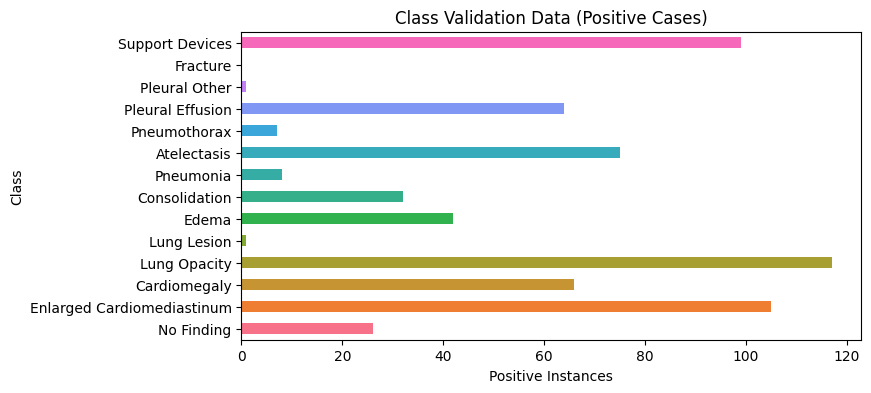

In [7]:
pathFileValid_df = pd.read_csv(pathFileValid)
class_counts = pathFileValid_df[class_names].sum()
print("Class Counts Valid dataset (number of positive cases):")
print(class_counts)
plt.figure(figsize=(8, 4))
colors = sns.color_palette("husl", len(class_counts))
class_counts.plot(kind='barh', color=colors)
plt.ylabel('Class')
plt.xlabel('Positive Instances')
plt.title('Class Validation Data (Positive Cases)')
plt.show()


In [8]:
len(Validdata)

202

Class Counts Test dataset:
No Finding                     50
Enlarged Cardiomediastinum     93
Cardiomegaly                   82
Lung Opacity                  273
Lung Lesion                    28
Edema                         182
Consolidation                 154
Pneumonia                      40
Atelectasis                   147
Pneumothorax                  192
Pleural Effusion              315
Pleural Other                  17
Fracture                       35
Support Devices               290
dtype: int64


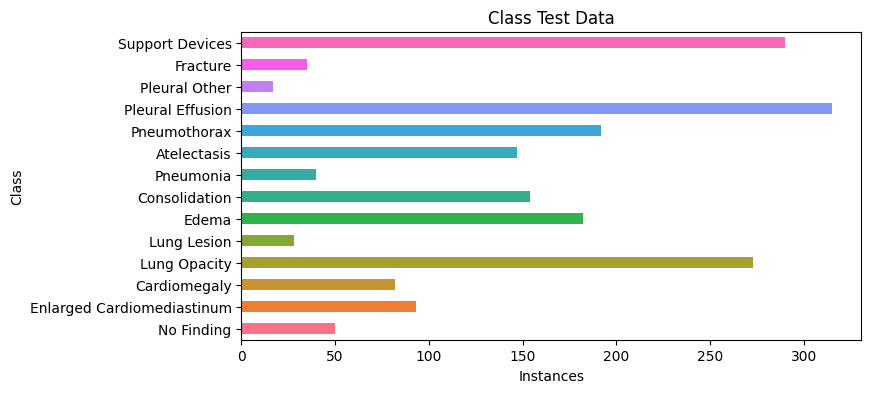

In [9]:
pathFileTest_df = pd.read_csv(pathFileTest)
class_counts = pathFileTest_df[class_names].count()
print("Class Counts Test dataset:")
print(class_counts)
plt.figure(figsize=(8, 4))
colors = sns.color_palette("husl", len(class_counts))
class_counts.plot(kind='barh', color=colors)
plt.ylabel('Class')
plt.xlabel('Instances')
plt.title('Class Test Data')
plt.show()


In [10]:
# ImageNet mean and std
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224)),  # RandomResizedCrop directly from original size
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        #transforms.RandomRotation(degrees=15),
        
        #transforms.ColorJitter(brightness=0.2, contrast=0.2),
        #transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),  # Random Gaussian Blur
    ], p=0.7),  # Adjust the probability as needed
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for validation
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])
class CheXpertDataSet(Dataset): # creating dataset  using  data_path which is path of dataset
    def __init__(self, data_PATH, transform=None , policy="ones"):
        self.class_names= ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax',
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

        image_names = []
        labels = []

        with open(data_PATH, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)  # skip the header
            for line in csvReader:
                image_name = line[0]
                label = line[5:]

                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            if policy == "ones":
                                label[i] = 1
                            elif policy == "zeroes":
                                label[i] = 0
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0

                image_names.append('/kaggle/input/chexpert-v10-small/' + image_name)
                labels.append(label)

        self.image_names = image_names
        self.labels = labels
        self.transform=transform
                                            

    def __getitem__(self, index):
        image_name = self.image_names[index]
        image = Image.open(image_name)

        # Check the number of channels in the image
        if image.mode != 'RGB':
            # Convert grayscale to RGB
            image = image.convert('RGB')

        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, torch.FloatTensor(label)


    def __len__(self):
        return len(self.image_names)

    def compute_class_counts(self):
        # Count occurrences of each class in the dataset
        class_counts = np.sum(np.array(self.labels), axis=0)
        return class_counts
# Load dataset
datasetTrain = CheXpertDataSet(pathFileTrain,transform, policy = "ones")
print("Train data length:", len(datasetTrain))

datasetValid = CheXpertDataSet(pathFileValid,val_transform)
print("Valid data length:", len(datasetValid))

datasetTest = CheXpertDataSet(pathFileTest,val_transform, policy = "ones")
print("Test data length:", len(datasetTest))

Train data length: 149500
Valid data length: 202
Test data length: 500


In [11]:
!pip install opacus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 3.5 MB/s eta 0:00:00


In [12]:
# Split the training data into subsets for each client
indices = np.random.permutation(len(datasetTrain))
split_length = len(indices) // num_clients
datasetsTrain = [Subset(datasetTrain, indices[i * split_length:(i + 1) * split_length]) for i in range(num_clients)]
dataLoadersTrain = [DataLoader(datasetsTrain[i], batch_size, shuffle=True, num_workers=4, pin_memory=True) for i in range(num_clients)]

# Create dataloaders for validation and test datasets
valid_loader = DataLoader(datasetValid, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(datasetTest, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)
val_loader=valid_loader

In [15]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import torch
from torch import nn, optim
from opacus import PrivacyEngine
from torch.utils.data import DataLoader
from opacus.utils.batch_memory_manager import BatchMemoryManager

class Trainer:
    @staticmethod
    def train(client_k, cfg, use_gpu,scheduler, checkpoint=None, freeze_mode='none'):
        """Train a local model from a client instance."""
        loss = torch.nn.BCEWithLogitsLoss()  # Setting binary cross-entropy as the loss function

        if checkpoint is not None:  # Load checkpoint
            modelCheckpoint = torch.load(checkpoint)
            client_k.model.load_state_dict(modelCheckpoint['state_dict'])
            client_k.optimizer.load_state_dict(modelCheckpoint['optimizer'])
        
        lossMIN = 100000
        params = client_k.model.state_dict().copy()

        train_start = []
        train_end = []
        save_epoch = []
        save_train_loss = []
        save_val_loss = []
        save_val_AUC = []
        save_epsilon = []
        save_alpha = []
        save_delta = []
        aurocIndividual = []

        for epochID in range(cfg['max_epochs']):
            train_start.append(time.time())
            losst = Trainer.epochTrain(client_k.model, client_k.train_loader, client_k.optimizer, loss, use_gpu, freeze_mode=freeze_mode)
            train_end.append(time.time())

            if client_k.val_loader is not None:
                print("Validating model from epoch ID...")
                lossv, aurocMean, outGT_val, outPRED_val = Trainer.epochVal(client_k.model, client_k.val_loader, loss, use_gpu, client_k)
                print(f"Training loss from epoch ID: {losst:.3f}, Validation loss from epoch ID: {lossv:.3f}")
            else:
                lossv, aurocMean = (np.nan, np.nan)
                params = client_k.model.state_dict().copy()

            model_num = epochID + 1
            torch.save({
                'epoch': model_num, 
                'state_dict': client_k.model.state_dict(),
                'loss': lossMIN, 
                'optimizer': client_k.optimizer.state_dict()
            }, f"{client_k.output_path}{model_num}-epoch_FL.pth.tar")

            if lossv < lossMIN:
                lossMIN = lossv
                print(f'Epoch {model_num} [++++] Validation loss decreased')
                params = client_k.model.state_dict().copy()
            else:
                print(f'Epoch {model_num} [----] Validation loss did not decrease or no validation data available')

            save_epoch.append(model_num)
            save_train_loss.append(losst)
            save_val_loss.append(lossv)
            save_val_AUC.append(aurocMean)
            aurocIndividual.append(Trainer.computeAUROC(outGT_val, outPRED_val))
            
            if scheduler is not None:
                scheduler.step(lossv)            
                # Print the current learning rate
                current_lr = client_k.optimizer.param_groups[0]['lr']
                print(f'Current learning rate: {current_lr}')
            else:
                print(f' previous  learning rate not updated')

            if cfg['track_norm']:
                grad_norm = []
                for p in filter(lambda p: p.grad is not None, client_k.model.parameters()):
                    cur_norm = p.grad.data.norm(2).item()
                    grad_norm.append(cur_norm)

    @staticmethod
    def epochTrain(model, dataLoaderTrain, optimizer, loss, use_gpu, freeze_mode='none'):
        """Train a model for one epoch."""
        losstrain = 0
        model.train()

        if freeze_mode == 'batch_norm':
            freeze_batchnorm(model)
        if freeze_mode == 'all_but_last':
            freeze_all_but_last(model)
        if freeze_mode == 'middle':
            freeze_middle(model)

        with BatchMemoryManager(
                data_loader=dataLoaderTrain,
                max_physical_batch_size=cfg['physical_batch_size'],
                optimizer=optimizer
            ) as memory_safe_data_loader:
            with tqdm(memory_safe_data_loader, unit='batch') as tqdm_loader:
                for varInput, target in tqdm_loader:
                    if use_gpu:
                        target = target.cuda(non_blocking=True)
                        varInput = varInput.cuda(non_blocking=True)

                    varOutput = model(varInput)  # Forward pass
                    lossvalue = loss(varOutput, target)

                    optimizer.zero_grad()  # Reset gradient
                    lossvalue.backward()
                    optimizer.step()

                    losstrain += lossvalue.item()
                    tqdm_loader.set_postfix(loss=lossvalue.item())

        return losstrain / len(dataLoaderTrain)

    @staticmethod
    def epochVal(model, dataLoaderVal, loss, use_gpu, client_k):
        model.eval()
        lossVal = 0

        outGT = torch.FloatTensor().cuda() if use_gpu else torch.FloatTensor()
        outPRED = torch.FloatTensor().cuda() if use_gpu else torch.FloatTensor()

        with torch.no_grad():
            for varInput, target in dataLoaderVal:
                if use_gpu:
                    target = target.cuda(non_blocking=True)
                    varInput = varInput.cuda(non_blocking=True)

                varOutput = model(varInput)
                lossVal += loss(varOutput, target).item()

                outGT = torch.cat((outGT, target), 0)
                outPRED = torch.cat((outPRED, varOutput), 0)

        auroc_individual = Trainer.computeAUROC(outGT, outPRED)
        auroc_mean = np.nanmean(np.array(auroc_individual))
        print(f'AUROC mean from epochVal: {auroc_mean:.4f}')

        return lossVal / len(dataLoaderVal), auroc_mean, outGT, outPRED

    @staticmethod
    def computeAUROC(dataGT, dataPRED):
        outAUROC = []
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()
        nnClassCount = dataGT.shape[1]

        for i in range(nnClassCount):
            try:
                outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
            except ValueError:
                print(f"AUROC not defined for label {i}")
                outAUROC.append(np.nan)

        return outAUROC

    @staticmethod
    def test(model, dataLoaderTest, class_idx, use_gpu, checkpoint=None):
        model.eval()
        nnClassCount = len(class_idx)

        outGT = torch.FloatTensor().cuda() if use_gpu else torch.FloatTensor()
        outPRED = torch.FloatTensor().cuda() if use_gpu else torch.FloatTensor()

        if checkpoint is not None:
            modelCheckpoint = torch.load(checkpoint)
            if 'state_dict' in modelCheckpoint:
                model.load_state_dict(modelCheckpoint['state_dict'])
            else:
                model.load_state_dict(modelCheckpoint)

        with torch.no_grad():
            for varInput, target in dataLoaderTest:
                if use_gpu:
                    target = target.cuda()
                    varInput = varInput.cuda()
                outGT = torch.cat((outGT, target), 0)
                outPRED = torch.cat((outPRED, model(varInput)), 0)

        aurocIndividual = Trainer.computeAUROC(outGT, outPRED)
        aurocMean = np.nanmean(np.array(aurocIndividual))
        print('AUROC mean from Test train part: {:.4f}'.format(aurocMean))

        if dataLoaderTest.dataset.class_names:
            print("Class indices provided:", class_idx)
            print("Number of class names available:", len(dataLoaderTest.dataset.class_names))
            print("Class names:", dataLoaderTest.dataset.class_names)

            for i in range(len(class_idx)):
                if class_idx[i] < len(dataLoaderTest.dataset.class_names):
                    print('{}: {:.4f}'.format(dataLoaderTest.dataset.class_names[class_idx[i]], aurocIndividual[i]))
                else:
                    print(f"Index {class_idx[i]} is out of range for class names")

        else:
            print("Class names not available.")

        return outGT, outPRED, aurocMean, aurocIndividual

from sklearn.metrics import roc_auc_score

def computeAUROC(outGT, outPRED):
    """Compute AUROC for each label."""
    aurocIndividual = []
    outGT = outGT.cpu().numpy()  # Convert to numpy array
    outPRED = outPRED.cpu().numpy()  # Convert to numpy array
    
    for i in range(outGT.shape[1]):
        try:
            auroc = roc_auc_score(outGT[:, i], outPRED[:, i])
            aurocIndividual.append(auroc)
        except ValueError:
            aurocIndividual.append(np.nan)
    
    return aurocIndividual


In [16]:
# Assuming class_idx is a list or an iterable
print("Length of class_idx:", len(class_idx))


Length of class_idx: 14


In [17]:
def check_path(path, warn_exists=True):
    if not os.path.exists(path):
        os.makedirs(path)
    elif warn_exists:
        print(f"Warning: Path {path} already exists.")
    return path

In [18]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=f14c63d3aa30c417a3e6a49bb29d217cea056249df26b4310e1ec377363a38e3
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [19]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator
from torch.utils.data import DataLoader
import random
import copy

from torchvision import models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from sklearn.metrics import accuracy_score, f1_score

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the HardSwish activation function
class HardSwish(nn.Module):
    def __init__(self):
        super(HardSwish, self).__init__()

    def forward(self, x):
        return x * (torch.clamp(x + 3, 0, 6) / 6)

# Define the model class
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b3')
        num_ftrs = self.model._fc.in_features
        self.model._fc = nn.Sequential(
            HardSwish(),
            
            nn.Linear(num_ftrs,num_classes),
            
        ) 
        
    def forward(self, x):
        return self.model(x)

In [20]:
#create global model
# Initialize global model
global_model1 = Net(num_classes)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 235MB/s]

Loaded pretrained weights for efficientnet-b3


In [21]:
# Optional: Validate and fix the model using ModuleValidator (if needed)
errors = ModuleValidator.validate(global_model1 , strict=False)
errors[-5:]


[opacus.validators.errors.ShouldReplaceModuleError("BatchNorm cannot support training with differential privacy. The reason for it is that BatchNorm makes each sample's normalized value depend on its peers in a batch, ie the same sample x will get normalized to a different value depending on who else is on its batch. Privacy-wise, this means that we would have to put a privacy mechanism there too. While it can in principle be done, there are now multiple normalization layers that do not have this issue: LayerNorm, InstanceNorm and their generalization GroupNorm are all privacy-safe since they don't have this property.We offer utilities to automatically replace BatchNorms to GroupNorms and we will release pretrained models to help transition, such as GN-ResNet ie a ResNet using GroupNorm, pretrained on ImageNet"),
 opacus.validators.errors.ShouldReplaceModuleError("BatchNorm cannot support training with differential privacy. The reason for it is that BatchNorm makes each sample's normal

In [22]:
global_model  = ModuleValidator.fix(global_model1 )
ModuleValidator.validate(global_model , strict=False)

[]

In [23]:
# Move global model to appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
checkpoint_path = '/kaggle/working/checkpoint.pth.tar'

In [25]:
global_model=torch.nn.DataParallel(global_model).cuda()
# Save the model to the specified checkpoint path
torch.save(global_model.state_dict(), checkpoint_path)

print("Saving checkpoint to:", checkpoint_path)

# Define output path
output_path = '/kaggle/working/'
os.makedirs(output_path, exist_ok=True)
# Define configurations

    # save initial global model parameters
#torch.save({'state_dict': global_model.state_dict()}, output_path+'global_init.pth.tar')


Saving checkpoint to: /kaggle/working/checkpoint.pth.tar


In [26]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Initialize the scheduler


In [27]:
# Define configurations
cfg = {
    
    
    'fraction': fraction,
    'sel_max_rounds':com_round,
    
    'physical_batch_size':60,
    #'reduce_lr_rounds': 3,
    #'earl_stop_rounds': 5,
    'private': True,
    'privacy_cfg': {
        'epsilon': privacy_epsilon, # Higher mean less privacy
        'min_delta': min_delta, # slightly increase for less privacy
        'max_grad_norm': max_grad_norm,
        'noise_multiplier':0.25,
        
    },
    'max_epochs': max_epochs,
    'optim': 'Adam',
    'lr': lr,
    'betas': betas,
    'eps': eps_optim,
    'batch_size': batch_size,
    'weight_decay': wtdecay,
    'track_norm': False
   
}


In [28]:
import copy
import torch
import torch.optim as optim
from opacus import PrivacyEngine
from opacus.accountants import RDPAccountant
from torch.utils.data import DataLoader

class Client():
    def __init__(self, name, global_model,  train_loader, cfg, output_path, val_loader=None, test_loader=None):
        self.name = name
        self.train_loader =  data_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.n_data = len(train_loader.dataset)
        self.model = copy.deepcopy(global_model)
        self.optimizer = None
        self.privacy_engine = None
        self.delta = None
        self.grad_norm = []
        self.output_path = output_path
        self.physical_batch_size = cfg['physical_batch_size']  # Add physical batch size
        self.privacy_metrics = []  # Add a list to store privacy metrics
        self.cfg = cfg  # Store cfg as an attribute
        self.selected_rounds = 0
  
  
        



    def init_optimizer(self, cfg):
        if self.model is not None:
            if cfg['optim'] == "Adam":
                optimizer = optim.Adam(self.model.parameters(), lr=cfg['lr'], betas=cfg['betas'], eps=cfg['eps'], weight_decay=cfg['weight_decay'])
            elif cfg['optim'] == "SGD":
                optimizer = optim.SGD(self.model.parameters(), lr=cfg['lr'])
            else:
                raise ValueError(f"Unsupported optimizer: {cfg['optim']}")
            
            # Adjust physical batch size for optimizer
            for param_group in optimizer.param_groups:
                param_group['params'][0] = next(self.model.parameters())
            
            self.optimizer = optimizer
        
        else:
            raise ValueError("Model is None. Optimizer cannot be initialized.")
        
        return self.optimizer
    def track_privacy_metrics(self, round_idx, accountant, sample_rate):
        if accountant is not None:
            privacy_spent = accountant.get_privacy_spent(delta=self.delta )
            epsilon, delta = privacy_spent[0], privacy_spent[1]
          
            self.privacy_metrics.append((int(round_idx), epsilon, delta))  # Store the metrics
            print(f"Client {self.name}: Round {round_idx}, Epsilon = {epsilon}, Delta = {delta}")
            # Print the noise multiplier (sigma)
            print(f"Client {client_k.name}: In track privacy Using sigma={client_k.optimizer.noise_multiplier}")
           
            
global_model = global_model.to(device)
# Initialize clients with physical batch size
clients = []
for i, data_loader in enumerate(dataLoadersTrain):
    client_name = f'Client_{i+1}'
    client = Client(client_name, global_model, data_loader, cfg, output_path, val_loader, test_loader)
    clients.append(client)

accountant = RDPAccountant()
for client in clients:
    sample_rate = 1 / len(client.train_loader)
    
for i, client_k in enumerate(clients):
    print(f"Initializing model and optimizer of {client_k.name}")
    
    client_k.model = copy.deepcopy(global_model)  # Deep copy of global model
    client_k.model.to(device)
    
    # Initialize optimizer
    client_k.optimizer = client_k.init_optimizer(cfg)

    if cfg['private']:
        if client_k.n_data is None:
            raise ValueError(f"Client {client_k.name} does not have n_data initialized.")
        
        client_k.delta = min(cfg['privacy_cfg']['min_delta'], 1 / client_k.n_data * 0.9)
        
        print(f'Client delta: {client_k.delta}')
        
        client_k.privacy_engine = PrivacyEngine()
        
        if hasattr(client_k.model, 'autograd_grad_sample_hooks'):
            del client_k.model.autograd_grad_sample_hooks
        
        client_k.model, client_k.optimizer, client_k.train_loader = client_k.privacy_engine.make_private_with_epsilon(
            module=client_k.model,
            optimizer=client_k.optimizer,
            data_loader=client_k.train_loader,
            epochs=cfg['sel_max_rounds'],
            target_epsilon=cfg['privacy_cfg']['epsilon'],
            target_delta=client_k.delta,
            max_grad_norm=cfg['privacy_cfg']['max_grad_norm'],
            
        )
        
        # Attach accountant hook to optimizer
        client_k.optimizer.attach_step_hook(accountant.get_optimizer_hook_fn(sample_rate=sample_rate))
        
        print(f"Client {client_k.name}: Epsilon={cfg['privacy_cfg']['epsilon']}, Delta={client_k.delta}")
        print(f"Client {client_k.name}: Gradient Norms: {cfg['privacy_cfg']['max_grad_norm']}")
        
    else:
        print(f"Privacy engine not initialized for {client_k.name}")
    client_k.val_loader = valid_loader
    client_k.test_loader = test_loader
# Initialize the global model and optimizer
global_model = copy.deepcopy(global_model)
test_model=copy.deepcopy(global_model)
test_model.to(device)

global_model.to(device)

if cfg['optim'] == "Adam":
    optimizer = optim.Adam(global_model.parameters(), lr=cfg['lr'], betas=cfg['betas'], eps=cfg['eps'], weight_decay=cfg['weight_decay'])
elif cfg['optim'] == "SGD":
    optimizer = optim.SGD(global_model.parameters(), lr=cfg['lr'])
else:
    raise ValueError(f"Unsupported optimizer: {cfg['optim']}")
privacy_engine = PrivacyEngine() # Make the global model private
global_model, optimizer, data_loader = privacy_engine.make_private_with_epsilon(
    module=global_model,
    optimizer=optimizer,
    data_loader=data_loader,
    epochs=cfg['max_epochs'],
    target_epsilon=cfg['privacy_cfg']['epsilon'],
    target_delta=cfg['privacy_cfg']['min_delta'],
    max_grad_norm=cfg['privacy_cfg']['max_grad_norm']
)



Initializing model and optimizer of Client_1
Client delta: 3.0100334448160535e-05


/opt/conda/lib/python3.10/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Client Client_1: Epsilon=15, Delta=3.0100334448160535e-05
Client Client_1: Gradient Norms: 1.2
Initializing model and optimizer of Client_2
Client delta: 3.0100334448160535e-05
Client Client_2: Epsilon=15, Delta=3.0100334448160535e-05
Client Client_2: Gradient Norms: 1.2
Initializing model and optimizer of Client_3
Client delta: 3.0100334448160535e-05
Client Client_3: Epsilon=15, Delta=3.0100334448160535e-05
Client Client_3: Gradient Norms: 1.2
Initializing model and optimizer of Client_4
Client delta: 3.0100334448160535e-05
Client Client_4: Epsilon=15, Delta=3.0100334448160535e-05
Client Client_4: Gradient Norms: 1.2
Initializing model and optimizer of Client_5
Client delta: 3.0100334448160535e-05
Client Client_5: Epsilon=15, Delta=3.0100334448160535e-05
Client Client_5: Gradient Norms: 1.2


In [29]:
print(f" after privacy engine Using sigma ={optimizer.noise_multiplier}")

 after privacy engine Using sigma =0.3757476806640625


In [31]:
import random
import time
import torch
import copy

scheduler_plateau = ReduceLROnPlateau(client_k.optimizer, mode='min', patience=5, factor=0.5, verbose=True)


global_auc = []
best_global_auc = 0
track_no_improv = 0

# Federated learning loop
for round_idx in range(cfg['sel_max_rounds']):
    print(f"[[[ Round {round_idx} Start ]]]")
    
    # Step 1: Select clients for this round
    if cfg['fraction'] < 1:
        sel_clients = random.sample(clients, round(len(clients) * cfg['fraction']))
        for sel_client in sel_clients:
            sel_client.selected_rounds += 1
        remaining_clients = [cp for cp in clients if cp.selected_rounds < cfg['sel_max_rounds']]
    else:
        sel_clients = clients
    
    print("Number of selected clients: ", len(sel_clients))
    print(f"Clients selected: {[sel_cl.name for sel_cl in sel_clients]}")

    # Step 2: Send global model to clients and train locally
    for client_k in sel_clients:
        if client_k.model is None:
            raise ValueError(f"{client_k.name}'s model is None. Ensure model initialization.")

        client_k.model.to(device)  # Move model to appropriate device (CPU or GPU)

        with torch.no_grad():
            for client_params, global_params in zip(client_k.model.parameters(), global_model.parameters()):
                client_params.data.copy_(global_params.data)

        print(f"<<<<<<<<<<<<<<<<<>>><<   {client_k.name} Training Start >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")

        client_index = clients.index(client_k)
        client_k.train_loader = dataLoadersTrain[client_index]
        client_k.val_loader = valid_loader  # Assign validation loader to each client

        if client_k.n_data is None:
            client_k.n_data = len(client_k.train_loader.dataset)
        
        
        train_valid_start = time.time()
        Trainer.train(client_k, cfg, use_gpu=torch.cuda.is_available(),scheduler=scheduler_plateau, checkpoint=None, freeze_mode='none')
        # Track privacy metrics after each epoch
        client_k.track_privacy_metrics(round_idx, accountant, sample_rate)
        
        client_k.model_params = client_k.model.state_dict().copy()
        train_valid_end = time.time()
        client_time = round(train_valid_end - train_valid_start)
        print(f"<<<<<<<<>>>>>>>>>>>> {client_k.name} Training Time: {client_time} seconds <<<<<<<<<<<>>>>>>>>")

    # Step 3: Aggregate updates with differential privacy considerations
    aggregated_model_params = {key: torch.zeros_like(param) for key, param in global_model.state_dict().items()}
    total_data_points = sum(client_k.n_data for client_k in sel_clients)

    for client_k in sel_clients:
        for key in client_k.model_params:
            aggregated_model_params[key] += client_k.model_params[key] * (client_k.n_data / total_data_points)

    # Step 4: Update global model with aggregated parameters
    global_model.load_state_dict(aggregated_model_params)
    torch.save({'state_dict': global_model.state_dict()}, f'Round_{round_idx + 1}_global_model.pth.tar')
    print("Global model updated")

# Save the final global model
torch.save({'state_dict': global_model.state_dict()}, 'Final_global_model.pth.tar')
print("Final model saved")


[[[ Round 0 Start ]]]
Number of selected clients:  4
Clients selected: ['Client_1', 'Client_3', 'Client_5', 'Client_4']
<<<<<<<<<<<<<<<<<>>><<   Client_1 Training Start >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:08,  1.70batch/s, loss=0.519]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.5298
Training loss from epoch ID: 0.873, Validation loss from epoch ID: 0.469
Epoch 1 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.443]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6335
Training loss from epoch ID: 0.867, Validation loss from epoch ID: 0.448
Epoch 2 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.448]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6028
Training loss from epoch ID: 0.860, Validation loss from epoch ID: 0.458
Epoch 3 [----] Validation loss did not decrease or no validation data available
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.411]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6229
Training loss from epoch ID: 0.857, Validation loss from epoch ID: 0.439
Epoch 4 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.418]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.5736
Training loss from epoch ID: 0.857, Validation loss from epoch ID: 0.454
Epoch 5 [----] Validation loss did not decrease or no validation data available
AUROC not defined for label 12
Current learning rate: 0.001
Client Client_1: Round 0, Epsilon = 21.43541136748762, Delta = 1.7
Client Client_1: In track privacy Using sigma=0.3575897216796875
<<<<<<<<>>>>>>>>>>>> Client_1 Training Time: 2738 seconds <<<<<<<<<<<>>>>>>>>
<<<<<<<<<<<<<<<<<>>><<   Client_3 Training Start >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:06,  1.71batch/s, loss=0.447]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.5300
Training loss from epoch ID: 0.876, Validation loss from epoch ID: 0.465
Epoch 1 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:04,  1.72batch/s, loss=0.398]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6264
Training loss from epoch ID: 0.873, Validation loss from epoch ID: 0.469
Epoch 2 [----] Validation loss did not decrease or no validation data available
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:04,  1.72batch/s, loss=0.379]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6072
Training loss from epoch ID: 0.867, Validation loss from epoch ID: 0.460
Epoch 3 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.407]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6206
Training loss from epoch ID: 0.862, Validation loss from epoch ID: 0.452
Epoch 4 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.72batch/s, loss=0.546]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6241
Training loss from epoch ID: 0.860, Validation loss from epoch ID: 0.454
Epoch 5 [----] Validation loss did not decrease or no validation data available
AUROC not defined for label 12
Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.
Current learning rate: 0.001
Client Client_3: Round 0, Epsilon = 27.782770383732245, Delta = 1.6
Client Client_3: In track privacy Using sigma=0.3575897216796875
<<<<<<<<>>>>>>>>>>>> Client_3 Training Time: 2735 seconds <<<<<<<<<<<>>>>>>>>
<<<<<<<<<<<<<<<<<>>><<   Client_5 Training Start >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:06,  1.71batch/s, loss=0.422]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.4956
Training loss from epoch ID: 0.874, Validation loss from epoch ID: 0.464
Epoch 1 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.0005


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.522]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.5673
Training loss from epoch ID: 0.867, Validation loss from epoch ID: 0.469
Epoch 2 [----] Validation loss did not decrease or no validation data available
AUROC not defined for label 12
Current learning rate: 0.0005


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.474]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.5546
Training loss from epoch ID: 0.866, Validation loss from epoch ID: 0.462
Epoch 3 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.0005


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.386]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.5873
Training loss from epoch ID: 0.862, Validation loss from epoch ID: 0.458
Epoch 4 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.0005


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.442]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6069
Training loss from epoch ID: 0.856, Validation loss from epoch ID: 0.462
Epoch 5 [----] Validation loss did not decrease or no validation data available
AUROC not defined for label 12
Current learning rate: 0.0005
Client Client_5: Round 0, Epsilon = 32.94673206896628, Delta = 1.5
Client Client_5: In track privacy Using sigma=0.3575897216796875
<<<<<<<<>>>>>>>>>>>> Client_5 Training Time: 2737 seconds <<<<<<<<<<<>>>>>>>>
<<<<<<<<<<<<<<<<<>>><<   Client_4 Training Start >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:06,  1.71batch/s, loss=0.503]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.4607
Training loss from epoch ID: 0.874, Validation loss from epoch ID: 0.465
Epoch 1 [++++] Validation loss decreased
AUROC not defined for label 12
Epoch 00016: reducing learning rate of group 0 to 2.5000e-04.
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.414]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6673
Training loss from epoch ID: 0.868, Validation loss from epoch ID: 0.454
Epoch 2 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.441]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6225
Training loss from epoch ID: 0.860, Validation loss from epoch ID: 0.445
Epoch 3 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.72batch/s, loss=0.394]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6252
Training loss from epoch ID: 0.858, Validation loss from epoch ID: 0.454
Epoch 4 [----] Validation loss did not decrease or no validation data available
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:04,  1.72batch/s, loss=0.392]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6386
Training loss from epoch ID: 0.856, Validation loss from epoch ID: 0.441
Epoch 5 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001
Client Client_4: Round 0, Epsilon = 37.62484074355878, Delta = 1.5
Client Client_4: In track privacy Using sigma=0.3575897216796875
<<<<<<<<>>>>>>>>>>>> Client_4 Training Time: 2736 seconds <<<<<<<<<<<>>>>>>>>
Global model updated
[[[ Round 1 Start ]]]
Number of selected clients:  4
Clients selected: ['Client_1', 'Client_5', 'Client_3', 'Client_4']
<<<<<<<<<<<<<<<<<>>><<   Client_1 Training Start >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.477]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6039
Training loss from epoch ID: 0.856, Validation loss from epoch ID: 0.446
Epoch 1 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:04,  1.72batch/s, loss=0.568]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6206
Training loss from epoch ID: 0.852, Validation loss from epoch ID: 0.448
Epoch 2 [----] Validation loss did not decrease or no validation data available
AUROC not defined for label 12
Epoch 00022: reducing learning rate of group 0 to 1.2500e-04.
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.542]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.5838
Training loss from epoch ID: 0.851, Validation loss from epoch ID: 0.443
Epoch 3 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:06,  1.71batch/s, loss=0.426]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6143
Training loss from epoch ID: 0.852, Validation loss from epoch ID: 0.438
Epoch 4 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:06,  1.71batch/s, loss=0.419]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6358
Training loss from epoch ID: 0.851, Validation loss from epoch ID: 0.436
Epoch 5 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001
Client Client_1: Round 1, Epsilon = 42.30294941815128, Delta = 1.5
Client Client_1: In track privacy Using sigma=0.3575897216796875
<<<<<<<<>>>>>>>>>>>> Client_1 Training Time: 2737 seconds <<<<<<<<<<<>>>>>>>>
<<<<<<<<<<<<<<<<<>>><<   Client_5 Training Start >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.375]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6378
Training loss from epoch ID: 0.864, Validation loss from epoch ID: 0.454
Epoch 1 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.000125


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:06,  1.71batch/s, loss=0.406]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6120
Training loss from epoch ID: 0.853, Validation loss from epoch ID: 0.450
Epoch 2 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.000125


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.431]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6070
Training loss from epoch ID: 0.851, Validation loss from epoch ID: 0.450
Epoch 3 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.000125


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.399]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6122
Training loss from epoch ID: 0.849, Validation loss from epoch ID: 0.450
Epoch 4 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.000125


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.401]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6164
Training loss from epoch ID: 0.848, Validation loss from epoch ID: 0.444
Epoch 5 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.000125
Client Client_5: Round 1, Epsilon = 46.010005591181695, Delta = 1.4
Client Client_5: In track privacy Using sigma=0.3575897216796875
<<<<<<<<>>>>>>>>>>>> Client_5 Training Time: 2738 seconds <<<<<<<<<<<>>>>>>>>
<<<<<<<<<<<<<<<<<>>><<   Client_3 Training Start >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.43]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6426
Training loss from epoch ID: 0.859, Validation loss from epoch ID: 0.446
Epoch 1 [++++] Validation loss decreased
AUROC not defined for label 12
Epoch 00031: reducing learning rate of group 0 to 6.2500e-05.
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:04,  1.72batch/s, loss=0.474]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6152
Training loss from epoch ID: 0.855, Validation loss from epoch ID: 0.443
Epoch 2 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.72batch/s, loss=0.415]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.5950
Training loss from epoch ID: 0.854, Validation loss from epoch ID: 0.465
Epoch 3 [----] Validation loss did not decrease or no validation data available
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:04,  1.72batch/s, loss=0.444]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.5851
Training loss from epoch ID: 0.854, Validation loss from epoch ID: 0.438
Epoch 4 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:04,  1.72batch/s, loss=0.471]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6107
Training loss from epoch ID: 0.853, Validation loss from epoch ID: 0.432
Epoch 5 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001
Client Client_3: Round 1, Epsilon = 49.689424501788125, Delta = 1.4
Client Client_3: In track privacy Using sigma=0.3575897216796875
<<<<<<<<>>>>>>>>>>>> Client_3 Training Time: 2734 seconds <<<<<<<<<<<>>>>>>>>
<<<<<<<<<<<<<<<<<>>><<   Client_4 Training Start >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.462]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.5910
Training loss from epoch ID: 0.858, Validation loss from epoch ID: 0.466
Epoch 1 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.72batch/s, loss=0.478]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6211
Training loss from epoch ID: 0.854, Validation loss from epoch ID: 0.459
Epoch 2 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:06,  1.71batch/s, loss=0.401]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6238
Training loss from epoch ID: 0.853, Validation loss from epoch ID: 0.447
Epoch 3 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:04,  1.72batch/s, loss=0.426]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6175
Training loss from epoch ID: 0.851, Validation loss from epoch ID: 0.448
Epoch 4 [----] Validation loss did not decrease or no validation data available
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.37]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.5967
Training loss from epoch ID: 0.852, Validation loss from epoch ID: 0.444
Epoch 5 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001
Client Client_4: Round 1, Epsilon = 53.368843412394554, Delta = 1.4
Client Client_4: In track privacy Using sigma=0.3575897216796875
<<<<<<<<>>>>>>>>>>>> Client_4 Training Time: 2736 seconds <<<<<<<<<<<>>>>>>>>
Global model updated
[[[ Round 2 Start ]]]
Number of selected clients:  4
Clients selected: ['Client_2', 'Client_4', 'Client_1', 'Client_5']
<<<<<<<<<<<<<<<<<>>><<   Client_2 Training Start >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:06,  1.71batch/s, loss=0.349]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6015
Training loss from epoch ID: 0.847, Validation loss from epoch ID: 0.437
Epoch 1 [++++] Validation loss decreased
AUROC not defined for label 12
Epoch 00041: reducing learning rate of group 0 to 3.1250e-05.
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.72batch/s, loss=0.429]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6164
Training loss from epoch ID: 0.848, Validation loss from epoch ID: 0.432
Epoch 2 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:04,  1.72batch/s, loss=0.497]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6242
Training loss from epoch ID: 0.849, Validation loss from epoch ID: 0.438
Epoch 3 [----] Validation loss did not decrease or no validation data available
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.409]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6148
Training loss from epoch ID: 0.849, Validation loss from epoch ID: 0.436
Epoch 4 [----] Validation loss did not decrease or no validation data available
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.72batch/s, loss=0.426]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6175
Training loss from epoch ID: 0.848, Validation loss from epoch ID: 0.430
Epoch 5 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001
Client Client_2: Round 2, Epsilon = 57.04826232300098, Delta = 1.4
Client Client_2: In track privacy Using sigma=0.3575897216796875
<<<<<<<<>>>>>>>>>>>> Client_2 Training Time: 2735 seconds <<<<<<<<<<<>>>>>>>>
<<<<<<<<<<<<<<<<<>>><<   Client_4 Training Start >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.455]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6013
Training loss from epoch ID: 0.848, Validation loss from epoch ID: 0.454
Epoch 1 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.41]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6200
Training loss from epoch ID: 0.846, Validation loss from epoch ID: 0.438
Epoch 2 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.444]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6145
Training loss from epoch ID: 0.846, Validation loss from epoch ID: 0.437
Epoch 3 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.446]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6183
Training loss from epoch ID: 0.846, Validation loss from epoch ID: 0.437
Epoch 4 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.349]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6415
Training loss from epoch ID: 0.846, Validation loss from epoch ID: 0.447
Epoch 5 [----] Validation loss did not decrease or no validation data available
AUROC not defined for label 12
Current learning rate: 0.001
Client Client_4: Round 2, Epsilon = 60.72768123360741, Delta = 1.4
Client Client_4: In track privacy Using sigma=0.3575897216796875
<<<<<<<<>>>>>>>>>>>> Client_4 Training Time: 2737 seconds <<<<<<<<<<<>>>>>>>>
<<<<<<<<<<<<<<<<<>>><<   Client_1 Training Start >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.418]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6278
Training loss from epoch ID: 0.847, Validation loss from epoch ID: 0.447
Epoch 1 [++++] Validation loss decreased
AUROC not defined for label 12
Epoch 00051: reducing learning rate of group 0 to 1.5625e-05.
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.491]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6203
Training loss from epoch ID: 0.846, Validation loss from epoch ID: 0.435
Epoch 2 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.416]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6296
Training loss from epoch ID: 0.847, Validation loss from epoch ID: 0.438
Epoch 3 [----] Validation loss did not decrease or no validation data available
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.398]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6286
Training loss from epoch ID: 0.846, Validation loss from epoch ID: 0.433
Epoch 4 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.383]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6181
Training loss from epoch ID: 0.845, Validation loss from epoch ID: 0.425
Epoch 5 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 0.001
Client Client_1: Round 2, Epsilon = 64.40710014421384, Delta = 1.4
Client Client_1: In track privacy Using sigma=0.3575897216796875
<<<<<<<<>>>>>>>>>>>> Client_1 Training Time: 2735 seconds <<<<<<<<<<<>>>>>>>>
<<<<<<<<<<<<<<<<<>>><<   Client_5 Training Start >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.381]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6037
Training loss from epoch ID: 0.849, Validation loss from epoch ID: 0.450
Epoch 1 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 1.5625e-05


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.425]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6070
Training loss from epoch ID: 0.847, Validation loss from epoch ID: 0.447
Epoch 2 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 1.5625e-05


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.72batch/s, loss=0.414]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6122
Training loss from epoch ID: 0.846, Validation loss from epoch ID: 0.446
Epoch 3 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 1.5625e-05


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.465]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6162
Training loss from epoch ID: 0.847, Validation loss from epoch ID: 0.446
Epoch 4 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 1.5625e-05


  0%|          | 0/499 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
935batch [09:05,  1.71batch/s, loss=0.448]

Validating model from epoch ID...


AUROC not defined for label 12
AUROC mean from epochVal: 0.6191
Training loss from epoch ID: 0.846, Validation loss from epoch ID: 0.444
Epoch 5 [++++] Validation loss decreased
AUROC not defined for label 12
Current learning rate: 1.5625e-05
Client Client_5: Round 2, Epsilon = 67.7417544761337, Delta = 1.3
Client Client_5: In track privacy Using sigma=0.3575897216796875
<<<<<<<<>>>>>>>>>>>> Client_5 Training Time: 2736 seconds <<<<<<<<<<<>>>>>>>>
Global model updated
Final model saved


In [32]:
# Final evaluation on the test set
outGT_test, outPRED_test, auc_mean_test, auc_individual_test = Trainer.test(global_model, test_loader, list(range(len(datasetTest.class_names))), use_gpu=torch.cuda.is_available())

print("Final Class-wise AUC scores on test set:")


AUROC mean from Test train part: 0.6245
Class indices provided: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Number of class names available: 14
Class names: ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
No Finding: 0.8006
Enlarged Cardiomediastinum: 0.5515
Cardiomegaly: 0.5916
Lung Opacity: 0.6016
Lung Lesion: 0.5917
Edema: 0.7211
Consolidation: 0.6046
Pneumonia: 0.4565
Atelectasis: 0.6099
Pneumothorax: 0.5436
Pleural Effusion: 0.6952
Pleural Other: 0.6591
Fracture: 0.6042
Support Devices: 0.7123
Final Class-wise AUC scores on test set:


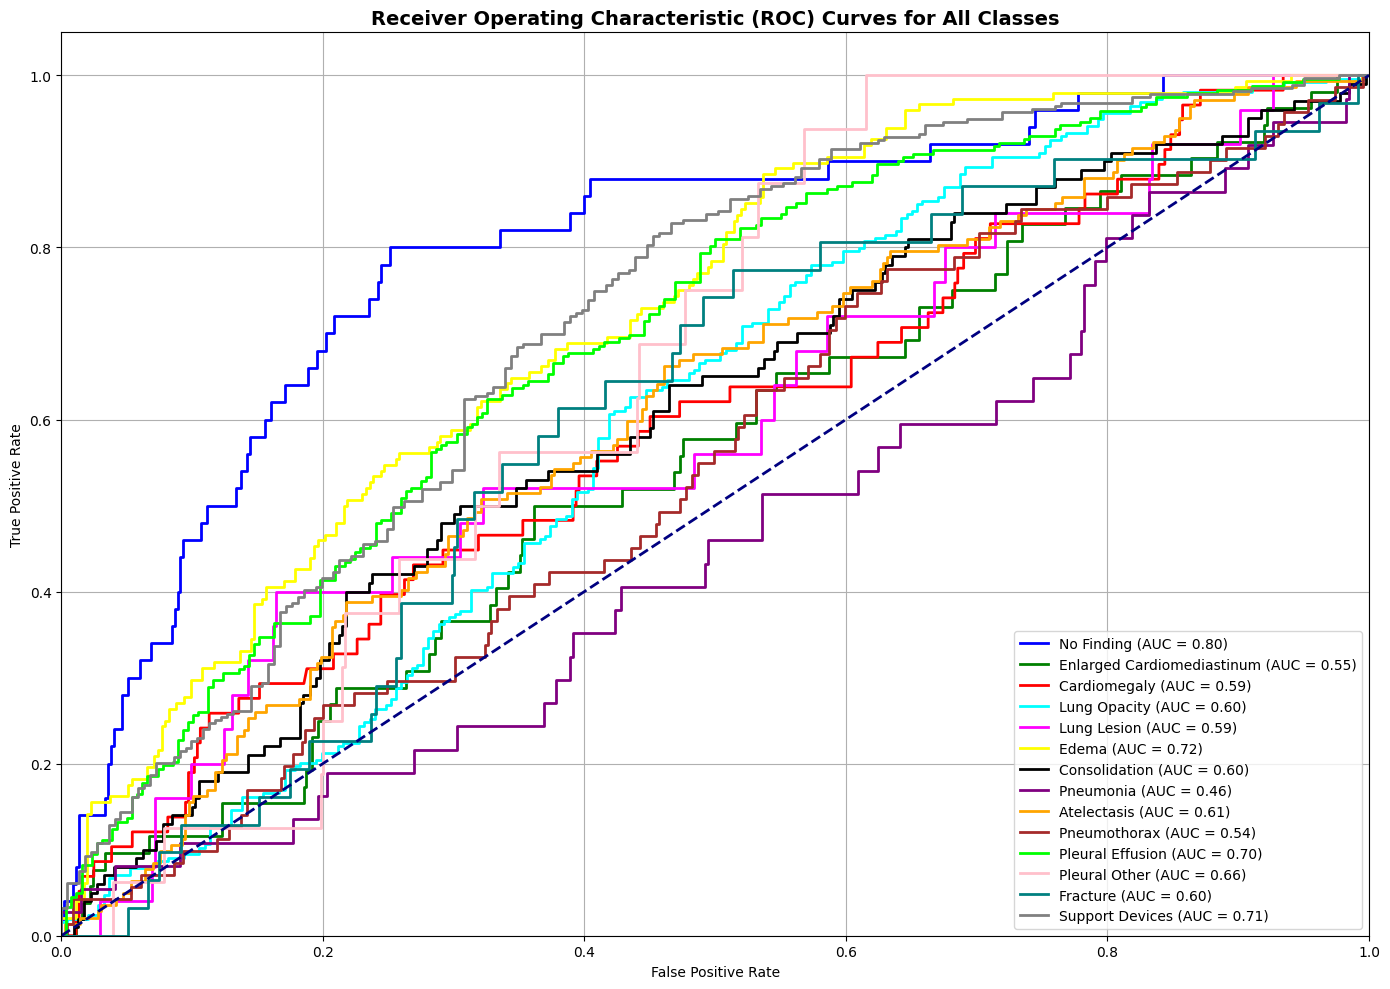

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch



# Convert tensors to numpy arrays
outGT_np = outGT_test.cpu().numpy()
outPRED_np = outPRED_test.cpu().numpy()

# Define the number of classes and class names



# Colors for each class
colors = [
    'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 
    'purple', 'orange', 'brown', 'lime', 'pink', 'teal', 'grey'
]

# Plot ROC curve for each class on a single graph
plt.figure(figsize=(14, 10))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(outGT_np[:, i], outPRED_np[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for All Classes', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.tight_layout()

plt.show()
